In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import xgboost as xgb


In [3]:
Nba2025 = pd.read_csv('../data/processed/NBA2025.csv')

Since the model was built with hyperparameter tuning, we do not need to tune the model again.
we can use the best model to predict the test data and evaluate the model.

In [4]:
xgb_model = joblib.load("../outputs/models/best_xgboost_model.pkl")


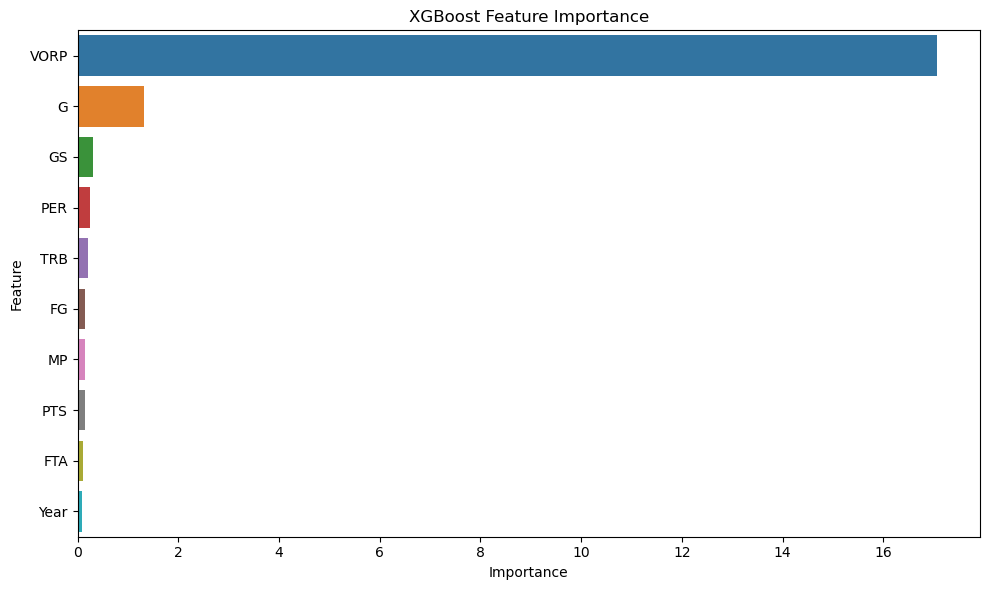

In [5]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

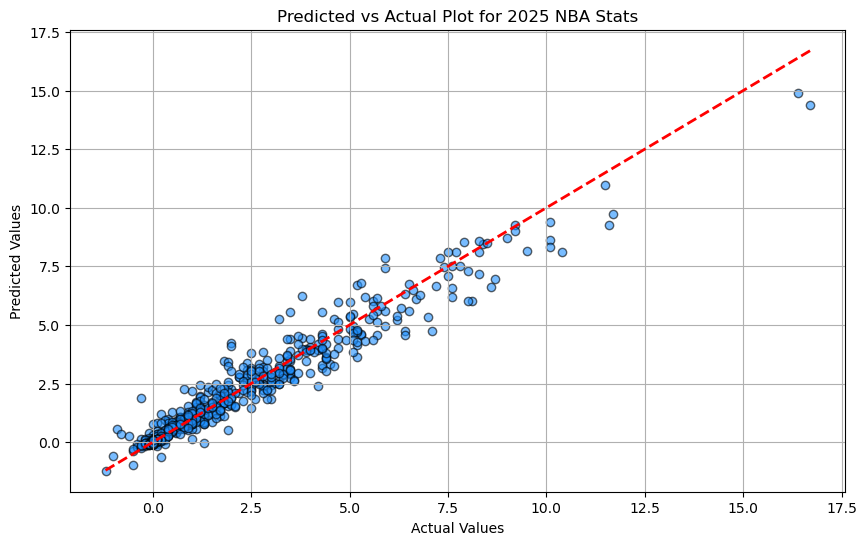

In [6]:
features = ['VORP', 'FG', 'TRB', 'PER', 'FTA', 'MP', 'GS', 'PTS', 'G', 'Year']  
y_2025_predict = xgb_model.predict(Nba2025[features])
y_2025_actual = Nba2025['WS']  # Replace 'target_column' with the actual target name

plt.figure(figsize=(10, 6))
plt.scatter(y_2025_actual, y_2025_predict, alpha=0.6, edgecolor='k', color='dodgerblue')
plt.plot([y_2025_actual.min(), y_2025_actual.max()], [y_2025_actual.min(), y_2025_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Plot for 2025 NBA Stats')
plt.grid(True)
plt.show()

In [7]:
#MSE and r2 score for test data
mse = mean_squared_error(y_2025_actual, y_2025_predict)
r2 = r2_score(y_2025_actual, y_2025_predict)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.38973810465392944
R-squared: 0.9404973721735351


The MSE of the model is around .39 which is a good model. The model is able to predict the win shares of the players with a good accuracy. The r2 score is .94 which means 94% of the variance in the data is explained by the model.

# Forecasting win shares for 2026 

In [8]:
Nba2025 = pd.read_csv('../data/processed/NBA2025.csv')

mean_vals = Nba2025.mean(numeric_only=True)
Nba2025.fillna(0, inplace=True)


In [9]:
features = [ 'VORP', 'FG',  'TRB',  'PER',  'FTA', 'MP', 'GS', 'PTS', 'G', 'Year']
target = ['WS']

In [10]:
df_2025 = Nba2025[Nba2025["Year"] == 2025].copy()
X_2026 = df_2025[features].copy()
X_2026["Year"] = 2026  # simulate the next season+= 1 

In [11]:
y_pred = xgb_model.predict(X_2026)

In [12]:
players_2026 = df_2025[["Player"]].copy()
players_2026["Year"] = 2026
players_2026["WS_pred"] = y_pred

In [13]:
players_2026.to_csv('2026_forecast.csv')

# Comparing Stats between year 2025 and 2026

In [14]:
df_2025.head()
Player_WS_2025 = df_2025[['Player', 'Year', 'WS']]
Player_WS_2025

,Player,Year,WS
0,Shai Gilgeous-Alexander,2025,16.7
1,Giannis Antetokounmpo,2025,11.5
2,Nikola Jokić,2025,16.4
3,Luka Dončić,2025,5.9
4,Anthony Edwards,2025,8.4
...,...,...,...
564,Riley Minix,2025,0.0
565,Jahlil Okafor,2025,0.0
566,Zyon Pullin,2025,0.0
567,Isaiah Stevens,2025,0.0


In [15]:
WS_compare = Player_WS_2025.merge(players_2026, on = 'Player', suffixes = ('_2025',"_2026"), how = 'left')
WS_compare.head()

,Player,Year_2025,WS,Year_2026,WS_pred
0,Shai Gilgeous-Alexander,2025,16.7,2026,14.368546
1,Giannis Antetokounmpo,2025,11.5,2026,10.985697
2,Nikola Jokić,2025,16.4,2026,14.880976
3,Luka Dončić,2025,5.9,2026,7.422618
4,Anthony Edwards,2025,8.4,2026,8.455515


In [16]:
WS_compare["WS_diff"] = WS_compare["WS_pred"] - WS_compare["WS"]
WS_compare.head()

,Player,Year_2025,WS,Year_2026,WS_pred,WS_diff
0,Shai Gilgeous-Alexander,2025,16.7,2026,14.368546,-2.331454
1,Giannis Antetokounmpo,2025,11.5,2026,10.985697,-0.514303
2,Nikola Jokić,2025,16.4,2026,14.880976,-1.519024
3,Luka Dončić,2025,5.9,2026,7.422618,1.522618
4,Anthony Edwards,2025,8.4,2026,8.455515,0.055515


In [17]:
most_improved = WS_compare.sort_values("WS_diff", ascending=False).head(5)
most_improved

,Player,Year_2025,WS,Year_2026,WS_pred,WS_diff
20,Victor Wembanyama,2025,3.8,2026,6.239006,2.439006
12,LaMelo Ball,2025,2.0,2026,4.230875,2.230875
124,Alex Sarr,2025,-0.3,2026,1.897693,2.197693
45,Jordan Poole,2025,2.0,2026,4.086226,2.086226
51,Scottie Barnes,2025,3.5,2026,5.569419,2.069419


In [18]:
most_regressed = WS_compare.sort_values("WS_diff").head(5)
most_regressed

,Player,Year_2025,WS,Year_2026,WS_pred,WS_diff
32,DeMar DeRozan,2025,7.1,2026,4.739189,-2.360811
0,Shai Gilgeous-Alexander,2025,16.7,2026,14.368546,-2.331454
117,Jarrett Allen,2025,11.6,2026,9.282310,-2.317690
61,Tyrese Haliburton,2025,10.4,2026,8.100097,-2.299903
44,Darius Garland,2025,8.1,2026,6.011772,-2.088228


In [19]:
#plot on bar graph
most_improved["Change"] = "Improved"
most_regressed ["Change"] = "Regressed"

WS_plot = pd.concat([most_improved, most_regressed])
WS_plot = WS_plot.sort_values("WS_diff", ascending=True)


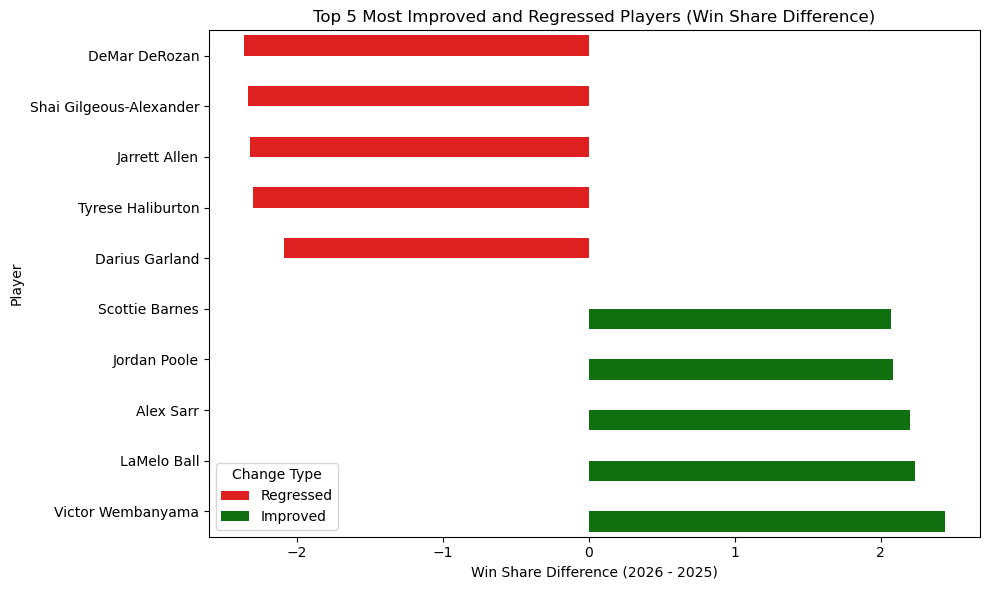

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="WS_diff", 
    y="Player", 
    hue="Change", 
    data=WS_plot, 
    palette={"Improved": "green", "Regressed": "red"}
)

plt.title("Top 5 Most Improved and Regressed Players (Win Share Difference)")
plt.xlabel("Win Share Difference (2026 - 2025)")
plt.ylabel("Player")
plt.legend(title="Change Type")
plt.tight_layout()
plt.show()